In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from scipy.stats import gamma, norm, beta, uniform
import scipy
from numba import njit
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist
from src.utils import printProgBar

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [4]:
# from config import mod4_params, mod7_params, fred_dict, recession_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_s', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_c': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [6]:
rbc = gEconModel(os.path.join(MODEL_DIR, 'mod4_rbc.gcn'))
nkm = gEconModel(os.path.join(MODEL_DIR, 'mod5_nk_capital.gcn'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 0 / 1 has a defined prior. 
	7 parameters
		 0 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.

Model Building Complete.
Found:
	18 equations
	18 variables
	The following variables were eliminated at user request:
		TC_t
	The following "variables" were defined as constants and have been substituted away:
		B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	12 parameters
		 0 / 12 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [7]:
_, rbc = solve_updated_mod(rbc)
_, nkm = solve_updated_mod(nkm)

Steady state found! Sum of squared residuals is 6.695239551090784e-23
Solution found, sum of squared residuals:  8.256002816550977e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.
Steady state found! Sum of squared residuals is 1.4252511608935836e-20
Solution found, sum of squared residuals:  2.0693357695302694e-26
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 7 eigenvalues greater than one in modulus and 5 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Kalman Filter Estimation

In [8]:
from scipy.stats import gamma, beta
prior_dist = {
    'alpha': beta(1.4, 10),
    # 'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=1.9, loc=0, scale=2.63157894736842),
    # 'eta_p': beta(2.4, 1.2),
    # 'eta_w': beta(2.4, 1.2),
    # 'phi_H': beta(1.2, 1.2),
    # 'epsilon_test': beta(1.2, 1.2),
    'epsilon_A': beta(1.2, 1.2),
    'epsilon_preference': beta(1.2, 1.2),
    'epsilon_R': beta(1.2, 1.2),
    'epsilon_T': beta(1.2, 1.2),
    'epsilon_Y': beta(1.2, 1.2),
    'epsilon_pi': beta(1.2, 1.2),
            }

## drawing from priors

In [12]:
mod = nkm
mod_params = nkm.free_param_dict

In [13]:
n_runs = 100
verbose = False

start = time.time()

n_param_dim_out = []
n_dim_out = []

ratio_list = np.array([[1, 0,0,0,0]])
loglike_list = [-1]
counter_accp = 0
counter_solved = 0

# reset params
mod.free_param_dict.update(mod_params)

# get params, variables and shocks as lists
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y", 'C']
model_params = list(mod.free_param_dict.keys())

posterior = {item: [mod.free_param_dict[item]] for item in model_params if item in prior_dist.keys()}
shock_posterior = {item: [0] for item in shock_names}

for i in range(0, n_runs):
    printProgBar(i, n_runs-1, prefix='Progress')
    
    # sample from priors
    new_prior, shocks = sample_from_priors(prior_dist, mod_params, shock_names)
    mod.free_param_dict.update(new_prior)
    
    is_solved, mod = solve_updated_mod(mod, verbose=verbose)
    if not is_solved:
        counter_solved += 0
        continue
    else:
        counter_solved += 1
    
    for key in shock_posterior.keys():
        shock_posterior[key].append(shocks[key])

    # get Kalman filter initial condition
    T, R = mod.T.values, mod.R.values
    H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                              shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables)
    
    # set up Kalman filter
    kfilter = KalmanFilter(len(state_variables), len(observed_vars))
    kfilter.F = T
    kfilter.Q = QN
    kfilter.H = Z
    kfilter.R = H

    # run Kalman filter
    saver = Saver(kfilter)
    mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
    ll = saver.log_likelihood
    
    new_loglike = np.sum(ll)
    loglike_list.append(new_loglike)
    
    
    #### MH #####
    old_loglike = loglike_list[-2]
    old_prior = {item: vals[-1] for item, vals in posterior.items()}
    
    # MH ratio
    ratio = ((new_loglike * get_arr_pdf_from_dist(new_prior, prior_dist)) / (old_loglike * get_arr_pdf_from_dist(old_prior, prior_dist))).mean()
    ω = min([ratio, 1])
    random = np.random.uniform(0, 1)
        
    
    # merge draws prior into posterior 
    if random <= ω:
        is_accepted = True
        counter_accp += 1.
        for key in new_prior.keys():
            posterior[key].append(new_prior[key])
            
    # leave posterior unaltered and restart
    else:
        is_accepted = False
        counter_accp += 0.
    
    
    
    # save output
    n_param_dim_out.append(
        [
            [posterior[item][-1] for item in posterior.keys()],
            list(new_prior.values()),
            list(get_arr_pdf_from_dist(new_prior, prior_dist))
        ]
    )
    
    ratio_list = np.append(ratio_list, [[new_loglike, ratio, ω, random, random <= ω]], axis=0)
        
n_param_dim_out = np.array(n_param_dim_out)
# n_dim_out = np.array(n_dim_out)
print('\nloop ran for', (time.time() - start) / 60, 'minutes')
print('\nacceptance rate', counter_accp/n_runs)

Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

loop ran for 0.4582241972287496 minutes

acceptance rate 0.75


In [15]:
# construct xarray
xarr = xr.Dataset(
    {
        'posterior': (['draw', 'parameter'], n_param_dim_out[:, 0]),
        'new_prior': (['draw', 'parameter'], n_param_dim_out[:, 1]),
        'new_prior_pdf': (['draw', 'parameter'], n_param_dim_out[:, 2]),
        'log_like': (['draw'], ratio_list[1:, 0]),
        'ratio': (['draw'], ratio_list[1:, 1]),
    },
    coords={
        'draw': (['draw'], list(range(0, counter_solved))),
        'parameter': (['parameter'], [item for item in mod_params if item in prior_dist.keys()])
    },
)
# xarr

In [19]:
# save output



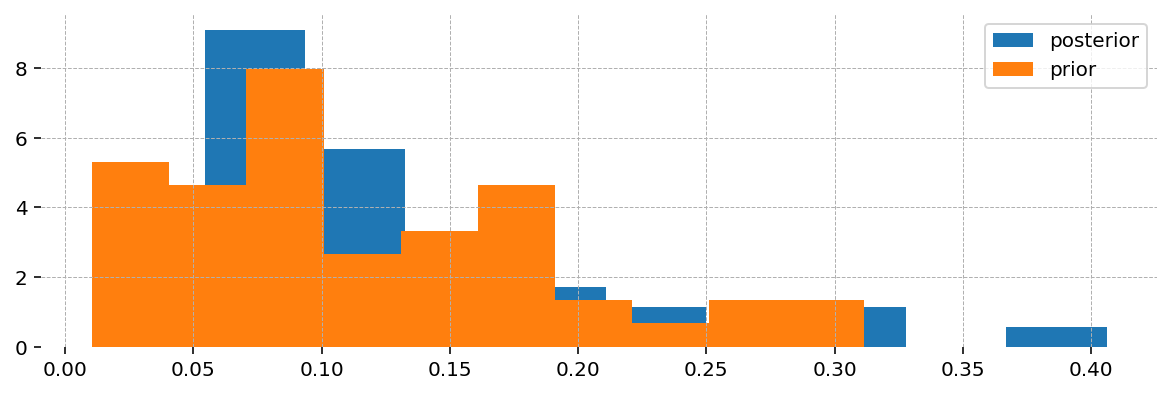

In [18]:
param = 'alpha'
bins = int(n_runs/10)
plt.hist(xarr.sel(parameter=param).posterior[int(n_runs/2):], bins=bins, density=True);
plt.hist([prior_dist[param].rvs() for item in np.linspace(0, 10, int(n_runs/2))], bins=bins, density=True);
plt.legend(['posterior', 'prior'])

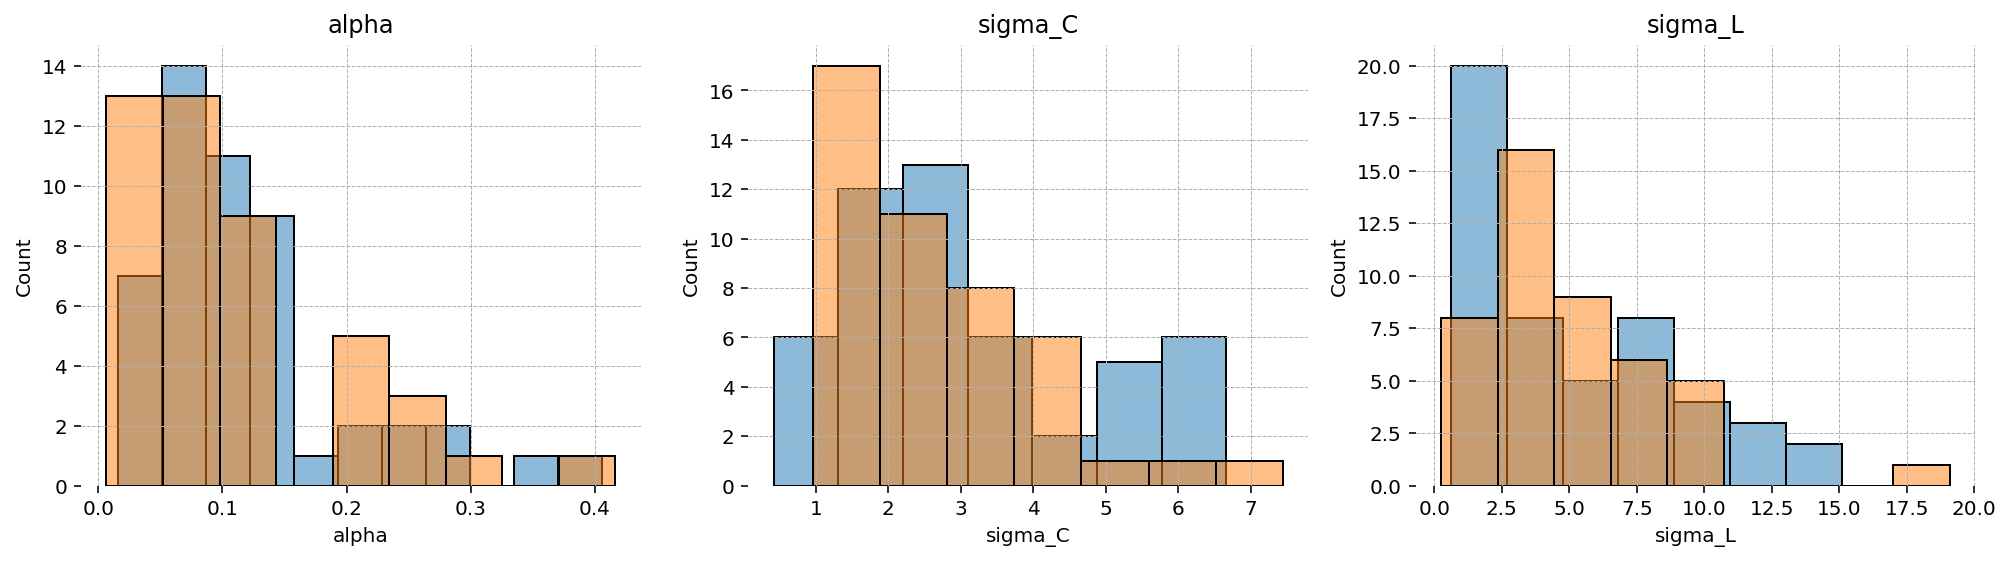

In [17]:
x = pd.DataFrame(xarr.posterior[int(counter_solved-n_runs/2):], columns=xarr.parameter)
x1 = pd.DataFrame([[prior_dist[param].rvs() for item in range(0, int(counter_solved-n_runs/2))] for param in xarr.parameter.values],
                  index=xarr.parameter).transpose()
plot_dfs([x, x1], sns.histplot, alpha=.5, legend=['posterior', 'prior'])

old code

In [ ]:
mod_list = [prior_dist, mod_params, shock_names, T, R, train[observed_vars].values, observed_vars, state_variables, mod.free_param_dict]
mod_dict = dict(zip(["prior_dist", "mod_params", "shock_names", "T", "R", "zs", "observed_vars", "state_variables", 'old_prior'], mod_list))

np.save(os.path.join(DATA_DIR, 'mod_test_dict.npy'), mod_dict)

import pickle
with open(os.path.join(DATA_DIR, 'mod_test_dict.pickle'), 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(mod_dict, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(DATA_DIR, 'mod_test_dict.pickle'), 'rb') as f:
    x = pickle.load(f)
